In [1]:
%reset -f
import numpy as np
from pandas import read_csv
from nn_models.SEIR_PINN import SEIR_PINN
from epidemic_model.SEIR_Model import SEIR_Model
import matplotlib.pyplot as plt
import torch
from utils.utils import load_data, parser

Data loaded from file:  data/Smoothed_Cases_Third_Wave.csv


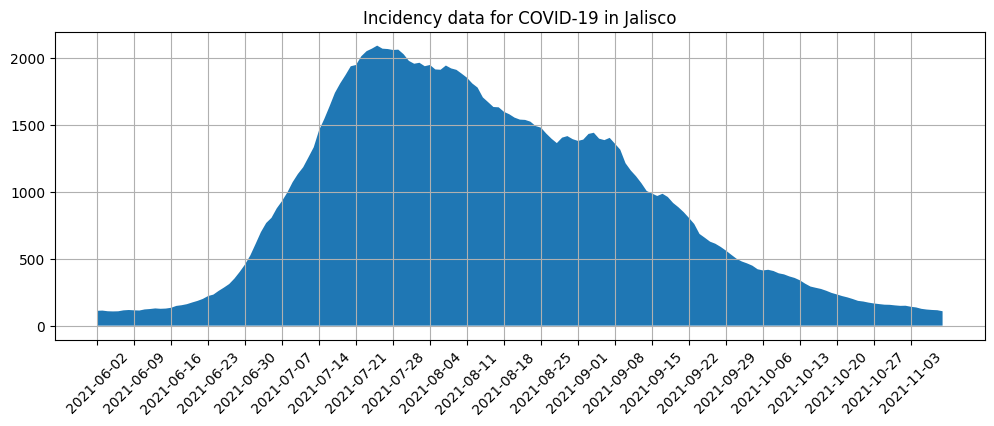

In [2]:
# Loading configuration from configuration file
fname_conf = './configuration_file_pinn.cfg'

params = parser(fname_conf)

times, data, dates = load_data(params['fname'])

print('Data loaded from file: ', params['fname'])

# plotting data
plt.figure(figsize=(12,4))
plt.fill_between(dates,data, label='Incidency data')
plt.xticks(dates[::7],rotation=45)
plt.title('Incidency data for COVID-19 in Jalisco')
plt.grid()
plt.show()

In [3]:
# setting initial values
# estimating initial conditions
N = params['N']

E0 = 0#data[0] 
I0 = 150#0.1*data[0]
R0 = 0
S0 = (N - E0 - I0 - R0)

x0 = np.array([S0,E0,I0,R0])

print(x0)

[2499850       0     150       0]


In [4]:
model = SEIR_PINN(RFF=False)

In [5]:
beta, sigma, gamma = model.run(times,
                               data,
                               x0,
                               params_0 = [6.0, 0.00145, 0.02],
                               #params_0 = [1.8559243450185814, 1.5257159035856744, 1.516536252764193],
                               epochs=params['iterations'],
                               lr=1e-4,
                               **params)

Iteración 0: Pérdida = 0.0102, eq: 134, data: 0.00883, cond: 3.57, [5.9994001388549805, 0.001450134557671845, 0.019999006763100624]
Iteración 1000: Pérdida = 0.00885, eq: 1.08, data: 0.00883, cond: 1.07, [5.865748405456543, 0.0015088975196704268, 0.01987701654434204]
Iteración 2000: Pérdida = 0.00883, eq: 0.237, data: 0.00883, cond: 0.359, [5.848365783691406, 0.0015279132639989257, 0.019898083060979843]
Iteración 3000: Pérdida = 0.00883, eq: 0.063, data: 0.00883, cond: 0.151, [5.840131759643555, 0.0015360942343249917, 0.019911589100956917]
Iteración 4000: Pérdida = 0.00883, eq: 0.0391, data: 0.00883, cond: 0.0712, [5.834921360015869, 0.0015401743585243821, 0.019921084865927696]
Iteración 5000: Pérdida = 0.00883, eq: 0.0257, data: 0.00883, cond: 0.0337, [5.829359531402588, 0.0015427557518705726, 0.019926557317376137]
Iteración 6000: Pérdida = 0.00883, eq: 0.0159, data: 0.00883, cond: 0.0167, [5.823151588439941, 0.0015444096643477678, 0.019931308925151825]
Iteración 7000: Pérdida = 0.008

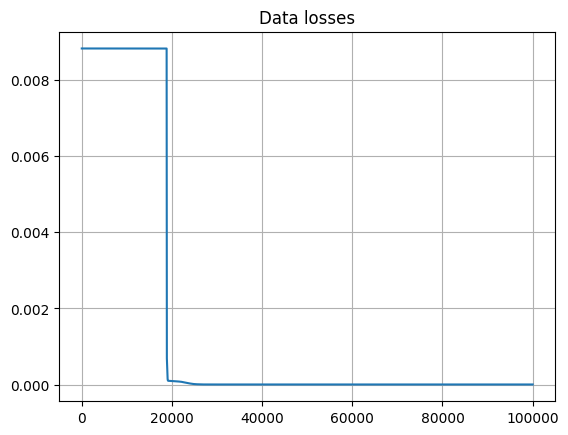

In [6]:
plt.figure()
plt.plot(model.data_losses)
plt.grid()
plt.title('Data losses')
plt.show()

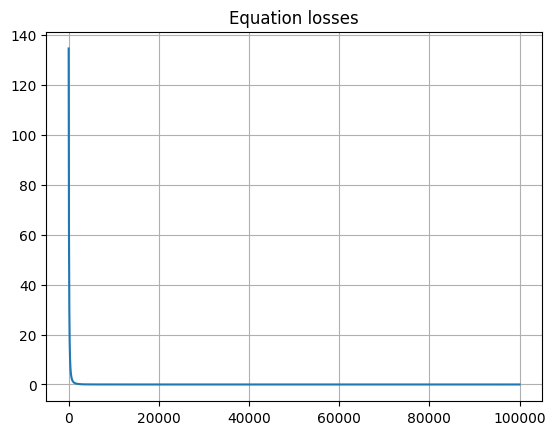

In [7]:
plt.figure()
plt.plot(model.eq_losses)
plt.grid()
plt.title('Equation losses')
plt.show()

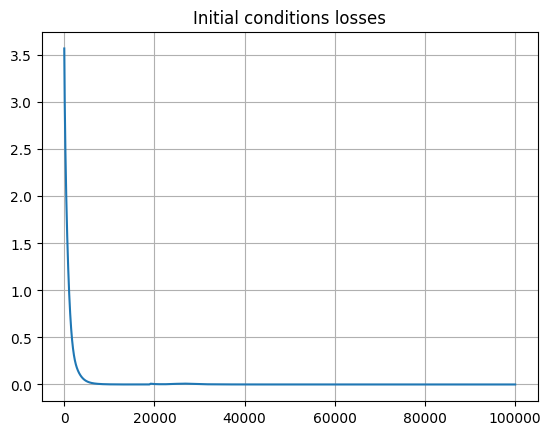

In [8]:
plt.figure()
plt.plot(model.cond_losses)
plt.grid()
plt.title('Initial conditions losses')
plt.show()

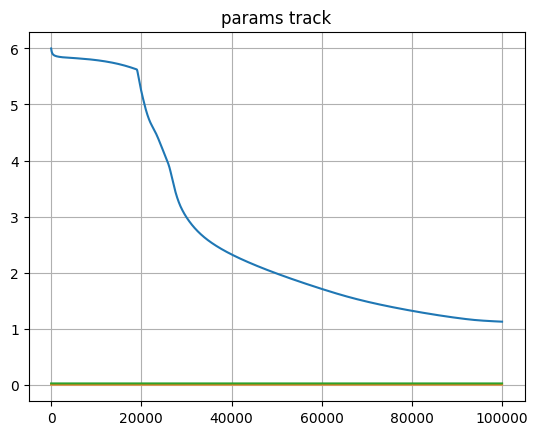

In [9]:
params_track = np.exp(np.array(model.params_track))

plt.figure()
plt.plot(params_track)
plt.grid()
plt.title('params track')
plt.show()

In [10]:
print(x0)
print(beta,sigma,gamma)
print(times)

[2499850       0     150       0]
1.1226235831532136 0.001960976855307898 0.019748959278258104
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160]


1.1226235831532136 0.001960976855307898 0.019748959278258104
[2441878.390927745, 57969.38872497609, 150, 2.220347278855581]


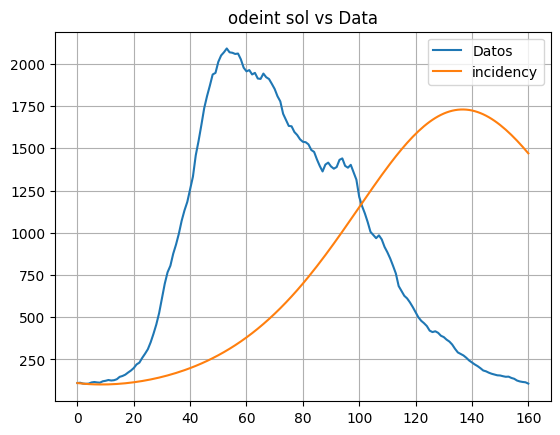

In [14]:

print(beta, sigma, gamma)

#beta, sigma, gamma = [0.4910216478152676, 0.2800019137444663, 0.22897669226675946]
#beta, sigma, gamma = [0.4976092079426683, 0.16907448091279353, 0.18131287897970613]
seir = SEIR_Model(beta, sigma, gamma, N)

if params['init_cond'] == 'estimated' :

    k = ((1.0+gamma)*data[1] - data[0])/sigma
    E1 = (sigma*k + gamma*I0 + data[0])/sigma
    E0 = E1 - k
    R0 = gamma*data[1]

    S0 = N - E0 - I0 - R0

    x0 = [S0, E0, I0, R0]

print(x0)
x = seir.run(x0, times)

if params['inc_method'] == 'susceptible':
    incidency = -seir.incidency(np.hstack([[N],x[0,:]]),times,1,method='susceptible')
elif params['inc_method'] == 'exposed':
    incidency = seir.incidency([x[1,:],x[2,:]],times,1,method='exposed',sigma=sigma, gamma=gamma)


#seir.plot(times,x)
plt.figure()
plt.plot(times, data, label='Datos')
plt.plot(times,incidency, label='incidency')
#plt.plot(times, x[2,:], 'g', label='Estimación Exp')
#plt.plot(times, x[1,:], 'r', label='Estimación Inf')
#plt.plot(times, x[0,:], 'steelblue', label='Estimación S')
#plt.plot(times, x[3,:], 'k', label='Estimación R')
plt.title('odeint sol vs Data')
plt.grid()
plt.legend()
plt.show()

exposed
[2500000.         2441878.39092775 2441651.83498932] [2441878.39092775 2441651.83498932 2441307.78836675] [-58121.60907225   -226.55593842   -344.04662258]
[2441878.390927745, 57969.38872497609, 150, 2.220347278855581]


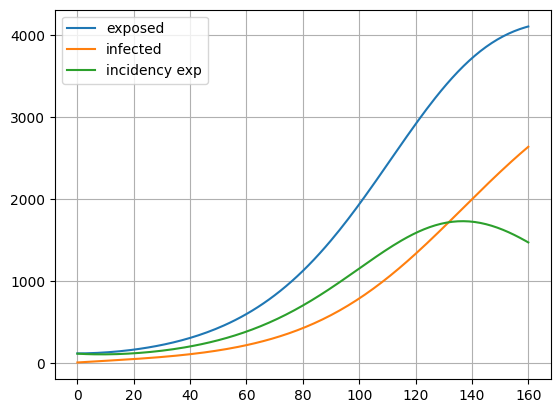

In [16]:
print(params['inc_method'])
incidency_exp = seir.incidency([x[1,:],x[2,:]],times,1,method='exposed',sigma=sigma, gamma=gamma)
incidency_sus = -seir.incidency(np.hstack([[N],x[0,:]]),times,1,method='susceptible',sigma=sigma, gamma=gamma)
plt.plot(sigma*x[1,:],label='exposed')
plt.plot(gamma*x[2,:],label='infected')
#plt.plot(sigma*x[1,:] - gamma*x[2,:],'o--',label='incidency')
#plt.plot(incidency_sus,label='incidency sus')
plt.plot(incidency_exp,label='incidency exp')
plt.grid()
plt.legend()
#print(x[0,:])
#print(np.hstack([[N],x[0,:]]))
P = np.hstack([[N],x[0,:]])
P_timestep = np.roll(P,-1)
inc = (P_timestep - P)[::1]
print(P[:3], P_timestep[:3], inc[:3])
print(x0)

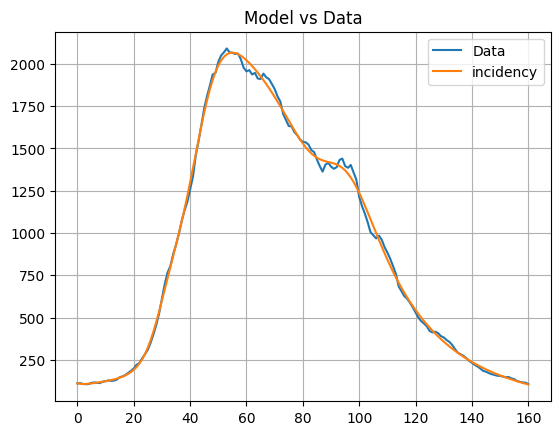

In [13]:

plt.figure()
times_tensor = torch.tensor(times, dtype=torch.float32).view(-1, 1)
y_pred = model.forward(times_tensor)

S_pred_denormalized = model.normalizer.denormalize(y_pred[:,0])
E_pred_denormalized = model.normalizer.denormalize(y_pred[:,1])
I_pred_denormalized = model.normalizer.denormalize(y_pred[:,2])

incidency = model.compute_incidency([E_pred_denormalized,I_pred_denormalized], N, method='exposed')

#incidency = sigma*E_pred_denormalized - gamma*I_pred_denormalized
#incidency = incidency = torch.nn.functional.softplus(incidency)

plt.plot(times, data, label='Data')
#plt.plot(times,N*y_pred[:,0], label='susceptible')
#plt.plot(times,E_pred_denomralized.numpy(), label='exposed')
#plt.plot(times,S_pred_denomralized.numpy(), label='infected')
with torch.no_grad() :
    #plt.plot(times,S_pred_denormalized,label='susceptible')
    #plt.plot(times,E_pred_denormalized, label='exposed')
    #plt.plot(times,I_pred_denormalized, label='infected')
    plt.plot(times,incidency,label='incidency')
plt.title('Model vs Data')
plt.grid()
plt.legend()
plt.show()